# heat_eqn_f4
This notebook will build two modules in which the overlay is controlled using pybind11 and CFFI respectively. The `.so` files will be copied into the `zypy/lib/` folder so they can be used with ZyPy. The generic initalisation code is found below. After that, four implementatiations will be made and compared: the default NumPy one, the hardware accelerated version using PYNQ, the hardware accelerated version using pybind11 and the hardware accelerated version using CFFI. A timing analysis at the end will reveal the minimum stream size required for the accelerators to be more beneficial than the default NumPy implementation. To build and do the analysis, click on `Kernel > Restart & Run All`.

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/heat_eqn_f4.bit")

M, N = 100, 100

x1 = allocate(shape=(M, N), dtype="f4")
x2 = allocate(shape=(M, N), dtype="f4")
out = allocate(shape=(M, N), dtype="f4")

x1[:] = np.random.rand(*x1.shape) + 1
x2[:] = np.random.rand(*x1.shape) + 1
out[:] = np.zeros(out.shape)

# NumPy
This is just a wrapper around the default NumPy implementation. The wrapper is required so we can compare it in the timing analysis.

In [2]:
def filter_avg_f4_numpy(x1, out):
    out[:] = x1[:]
    out[1:-1, 1:-1] = 0.2 * (
      x1[1:-1, 1:-1] +
      x1[:-2, 1:-1] +
      x1[2:, 1:-1] +
      x1[1:-1, :-2] +
      x1[1:-1, 2:]
    )

def sad_reduce_all_f4_numpy(x1, x2):
    return np.sum(np.abs(x1 - x2))

out[:] = 0
filter_avg_f4_numpy(x1, out)
print(f"filter_avg_f4_numpy = {out}")

out[:] = 0
print(f"sad_reduce_all_f4_numpy = {sad_reduce_all_f4_numpy(x1, x2)}")

filter_avg_f4_numpy = [[1.4744306 1.392718  1.0038372 ... 1.0670781 1.5287384 1.0682884]
 [1.5446355 1.4628501 1.4585795 ... 1.5536247 1.7643473 1.6567457]
 [1.1234454 1.4070776 1.6740433 ... 1.5484227 1.6770416 1.3967685]
 ...
 [1.8690549 1.6477486 1.5386388 ... 1.6178659 1.461311  1.5569026]
 [1.095905  1.5776415 1.5963141 ... 1.4377866 1.4215307 1.0363798]
 [1.37695   1.4045794 1.3981141 ... 1.2788327 1.8470112 1.1097506]]
sad_reduce_all_f4_numpy = 3360.200927734375


# PYNQ
This is the default PYNQ implementation, in which the AXI4-Lite registers are controlled using the built-in MMIO module.

In [3]:
from struct import pack, unpack

def to_float(u32):
    return unpack('f', pack('I', u32))[0]

def filter_avg_f4_pynq(x1, out):
    overlay.filter_avg_f4_0.mmio.write(0x10, (x1.shape[0] << 0) | (x1.shape[1] << 16))  # Set args
    overlay.filter_avg_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axis_switch_0.mmio.write(0x40 + 4 * 0, 0)  # Route master 0 to slave 0
    overlay.axis_switch_0.mmio.write(0x40 + 4 * 1, 0x8000_0000)  # Disable master 1
    overlay.axis_switch_0.mmio.write(0x40 + 4 * 2, 0x8000_0000)  # Disable master 2
    overlay.axis_switch_0.mmio.write(0x40 + 4 * 3, 2)  # Route master 3 to slave 2
    x = overlay.axis_switch_0.mmio.read(0x00)
    overlay.axis_switch_0.mmio.write(0x00, (x | 0x2))  # Do the update

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def sad_reduce_all_f4_pynq(x1, x2):
    overlay.sad_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axis_switch_0.mmio.write(0x40 + 4 * 0, 0x8000_0000)  # Disable master 0
    overlay.axis_switch_0.mmio.write(0x40 + 4 * 1, 0)  # Route master 1 to slave 0
    overlay.axis_switch_0.mmio.write(0x40 + 4 * 2, 1)  # Route master 2 to slave 1
    overlay.axis_switch_0.mmio.write(0x40 + 4 * 3, 0x8000_0000)  # Disable master 3
    x = overlay.axis_switch_0.mmio.read(0x00)
    overlay.axis_switch_0.mmio.write(0x00, (x | 0x2))  # Do the update

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)

    while not (overlay.sad_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.sad_reduce_all_f4_0.mmio.read(0x10)
    
    return to_float(out)

out[:] = 0
filter_avg_f4_pynq(x1, out)
print(f"filter_avg_f4_pynq = {out}")

out[:] = 0
print(f"sad_reduce_all_f4_pynq = {sad_reduce_all_f4_pynq(x1, x2)}")

filter_avg_f4_pynq = [[1.4744306 1.392718  1.0038372 ... 1.0670781 1.5287384 1.0682884]
 [1.5446355 1.4628502 1.4585795 ... 1.5536246 1.7643473 1.6567457]
 [1.1234454 1.4070777 1.674043  ... 1.5484227 1.6770416 1.3967685]
 ...
 [1.8690549 1.6477488 1.538639  ... 1.6178659 1.461311  1.5569026]
 [1.095905  1.5776415 1.5963143 ... 1.4377865 1.4215306 1.0363798]
 [1.37695   1.4045794 1.3981141 ... 1.2788327 1.8470112 1.1097506]]
sad_reduce_all_f4_pynq = 3360.200927734375


# pybind11
This is the pybind11 implementation, in which all registers are controlled by `mmap`ing the physical memory `/dev/mem/`.

In [4]:
%%pybind11 heat_eqn_f4_pybind11

#include "defines.h"

float to_float(unsigned int val) {
    union {
        unsigned int u4;
        float f4;
    } data = {val};

    return data.f4;
}

void filter_avg_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int height, unsigned int width)
{
    init();
    
    filter_avg_f4_0_args_args_w(((height << 0) | (width << 16)));
    filter_avg_f4_0_ctrl_ap_start_rw(0x1);

    axis_switch_0_route_m_to_s(0, 0);
    axis_switch_0_disable_m(1);
    axis_switch_0_disable_m(2);
    axis_switch_0_route_m_to_s(3, 2);
    axis_switch_0_update();

    unsigned int length = height * width * sizeof(float); 

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    
    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(length);
    
    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(length);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

float sad_reduce_all_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes)
{
    init();
    
    sad_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axis_switch_0_disable_m(0);
    axis_switch_0_route_m_to_s(1, 0);
    axis_switch_0_route_m_to_s(2, 1);
    axis_switch_0_disable_m(3);
    axis_switch_0_update();

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    while(!(sad_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(sad_reduce_all_f4_0_ap_return_ap_return_r());
    
    exit();

    return res; 
}

In [5]:
# This cell writes the above source code to a file, so that it can be reused for the CFFI implementation.
# Please make sure the cell above is the last cell executed!

with open(f"heat_eqn_f4.c", "w") as f:
    code = ("#" + _ih[-2].split("#", 1)[1])[:-2].replace("\\n", "\n")
    f.write(code)

In [6]:
import heat_eqn_f4_pybind11 as calc

def filter_avg_f4_pybind11(x1, out):
    calc.filter_avg_f4(x1.physical_address, out.physical_address, *x1.shape)

def sad_reduce_all_f4_pybind11(x1, x2):
    return calc.sad_reduce_all_f4(x1.physical_address, x2.physical_address, x1.nbytes)

out[:] = 0
filter_avg_f4_pybind11(x1, out)
print(f"filter_avg_f4_pybind11 = {out}")

out[:] = 0
print(f"sad_reduce_all_f4_pybind11 = {sad_reduce_all_f4_pybind11(x1, x2)}")

filter_avg_f4_pybind11 = [[1.4744306 1.392718  1.0038372 ... 1.0670781 1.5287384 1.0682884]
 [1.5446355 1.4628502 1.4585795 ... 1.5536246 1.7643473 1.6567457]
 [1.1234454 1.4070777 1.674043  ... 1.5484227 1.6770416 1.3967685]
 ...
 [1.8690549 1.6477488 1.538639  ... 1.6178659 1.461311  1.5569026]
 [1.095905  1.5776415 1.5963143 ... 1.4377865 1.4215306 1.0363798]
 [1.37695   1.4045794 1.3981141 ... 1.2788327 1.8470112 1.1097506]]
sad_reduce_all_f4_pybind11 = 3360.200927734375


# CFFI
This is the CFFI implementation, of which the source code is identical to the pybind11 implementation.
The only thing that needs to be added are the C definitions.

In [7]:
%%writefile build_heat_eqn_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

# Add all C definitions below...

ffibuilder.cdef(
    r"""
void filter_avg_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int height, unsigned int width);
float sad_reduce_all_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes);
    """
)

with open("heat_eqn_f4.c") as f:
    ffibuilder.set_source("heat_eqn_f4_cffi", f.read())

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing build_heat_eqn_f4_cffi.py


In [8]:
%%bash

/home/xilinx/perf_env/bin/python  build_heat_eqn_f4_cffi.py
cp heat_eqn_f4_cffi.cpython-37m-arm-linux-gnueabihf.so ../
cp heat_eqn_f4_pybind11.so ../

generating ./heat_eqn_f4_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/zypy/lib/heat_eqn_f4'
running build_ext
building 'heat_eqn_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c heat_eqn_f4_cffi.c -o ./heat_eqn_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./heat_eqn_f4_cffi.o -o ./heat_eqn_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In file included from heat_eqn_f4_cffi.c:569:0:
defines.h:193:15: warning: backslash-newline at end of file
 #define exit()\
                


In [9]:
from heat_eqn_f4_cffi import lib as calc

def filter_avg_f4_cffi(x1, out):
    calc.filter_avg_f4(x1.physical_address, out.physical_address, *x1.shape)

def sad_reduce_all_f4_cffi(x1, x2):
    return calc.sad_reduce_all_f4(x1.physical_address, x2.physical_address, x1.nbytes)

out[:] = 0
filter_avg_f4_cffi(x1, out)
print(f"filter_avg_f4_pybind11 = {out}")

out[:] = 0
print(f"sad_reduce_all_f4_pybind11 = {sad_reduce_all_f4_cffi(x1, x2)}")

filter_avg_f4_pybind11 = [[1.4744306 1.392718  1.0038372 ... 1.0670781 1.5287384 1.0682884]
 [1.5446355 1.4628502 1.4585795 ... 1.5536246 1.7643473 1.6567457]
 [1.1234454 1.4070777 1.674043  ... 1.5484227 1.6770416 1.3967685]
 ...
 [1.8690549 1.6477488 1.538639  ... 1.6178659 1.461311  1.5569026]
 [1.095905  1.5776415 1.5963143 ... 1.4377865 1.4215306 1.0363798]
 [1.37695   1.4045794 1.3981141 ... 1.2788327 1.8470112 1.1097506]]
sad_reduce_all_f4_pybind11 = 3360.200927734375


# Timing analysis
The timing analysis is done for each of the functions that is accelerated in hardware. The values of the stream size for which the hardware implementation provides acceleration are given by `pynq_min`, `pybind11_min` and `cffi_min` respectively. Equivalently `pynq_min_reconf`, `pybind11_min_reconf` and `cffi_min_recong` indicate the size required in case reconfiguration is taken into account as well.

## filter_avg_f4


kernel = numpy, n = 16, t = 0.0022461111000000003
kernel = pynq, n = 16, t = 0.3058483039
kernel = pybind11, n = 16, t = 0.0010233606
kernel = cffi, n = 16, t = 0.0003211825
kernel = numpy, n = 32, t = 0.0021624722000000004
kernel = pynq, n = 32, t = 0.3508243253
kernel = pybind11, n = 32, t = 0.00047818800000000005
kernel = cffi, n = 32, t = 0.0002101895
kernel = numpy, n = 64, t = 0.0024402378
kernel = pynq, n = 64, t = 0.339675989
kernel = pybind11, n = 64, t = 0.000476158
kernel = cffi, n = 64, t = 0.00020001100000000002
kernel = numpy, n = 128, t = 0.0025122428
kernel = pynq, n = 128, t = 0.34599564600000005
kernel = pybind11, n = 128, t = 0.0004636422
kernel = cffi, n = 128, t = 0.00020201170000000004
kernel = numpy, n = 256, t = 0.0026286212000000003
kernel = pynq, n = 256, t = 0.3211689958
kernel = pybind11, n = 256, t = 0.0002030363
kernel = cffi, n = 256, t = 0.0002140502
kernel = numpy, n = 512, t = 0.0026378624
kernel = pynq, n = 512, t = 0.3683068819
kernel = pybind11, n =

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 0.000140381943750… │ 0.01911551899375  │ 6.39600375e-05     │ 2.007390625e-05   │
│ 32      │ 6.757725625000001… │ 0.010963260165625 │ 1.494337500000000… │ 6.568421875e-06   │
│ 64      │ 3.8128715625e-05   │ 0.005307437328125 │ 7.43996875e-06     │ 3.12517187500000… │
│ 128     │ 1.9626896875e-05   │ 0.00270309098437… │ 3.6222046875e-06   │ 1.57821640625000… │
│ 256     │ 1.026805156250000… │ 0.00125456638984… │ 7.93110546875e-07  │ 8.3613359375e-07  │
│ 512     │ 5.152075e-06       │ 0.00071934937871… │ 4.01339453125e-07  │ 3.92189843750000… │
│ 1024    │ 2.88239990234375e… │ 0.00033463171796… │ 2.10405078125e-07  │ 2.67954296875000… │
│ 2048    │ 1.529794042968750… │ 0.00014921244741… │ 2.320340332031250… │ 1.05325781250000… │
│ 4096    │ 1.013077490234375… │ 7.47896751953125… │ 6.7628076171875e-… │ 7.4079541015625e… │
│ 8192    │ 7.201445678710938… │ 3.73462465698242… │ 3.809367675781250… │ 5.15587402343750… │
│ 16384   │ 5.77818115234375e… │ 1.91720567260742… │ 2.516917114257812… │ 3.143896484375e-… │
│ 32768   │ 4.651710083007812… │ 9.33640479736328… │ 2.460419921875e-08 │ 2.04379852294921… │
│ 65536   │ 4.906147781372071… │ 4.67335909118652… │ 1.438607177734375… │ 1.41402786254882… │
│ 131072  │ 4.777596542358399… │ 2.33674884872436… │ 1.245628433227539… │ 1.22834144592285… │
│ 262144  │ 4.979062492370605… │ 1.16885161361694… │ 1.138255424499511… │ 1.13043315887451… │
│ 524288  │ 4.876730979919434… │ 5.84286465454101… │ 1.082175331115722… │ 1.07740003585815… │
│ 1048576 │ 4.859751512527466… │ 2.93624280071258… │ 1.048907184600830… │ 1.04941273689270… │
│ 2097152 │ 4.830279460430146… │ 1.47463104009628… │ 1.030727119445800… │ 1.03085496902465… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

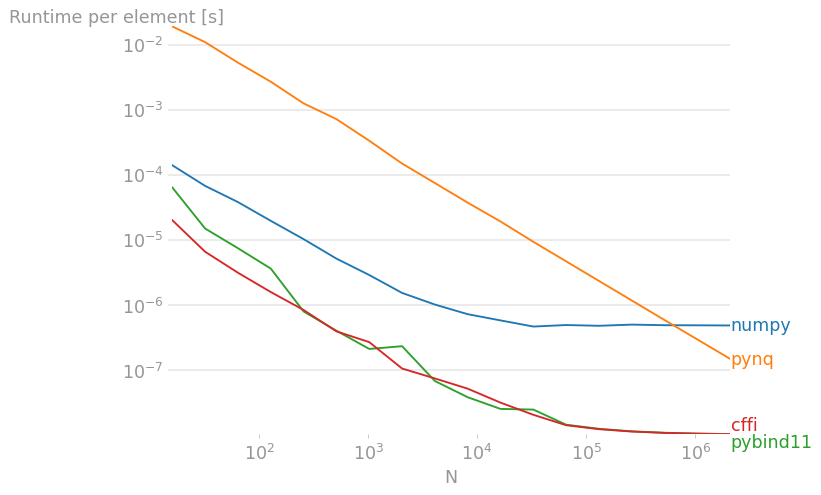

pynq_min = 524288
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.220329409


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 0.000140381943750… │ 0.03288610705625  │ 0.0138345481       │ 0.01379066196875  │
│ 32      │ 6.757725625000001… │ 0.017848554196875 │ 0.00690023740625   │ 0.00689186245312… │
│ 64      │ 3.8128715625e-05   │ 0.00875008434375  │ 0.003450086984375  │ 0.0034457721875   │
│ 128     │ 1.9626896875e-05   │ 0.00442441449218… │ 0.0017249457125    │ 0.00172290172421… │
│ 256     │ 1.026805156250000… │ 0.00211522814375  │ 0.000861454864453… │ 0.0008614978875   │
│ 512     │ 5.152075e-06       │ 0.00114968025566… │ 0.000430732216406… │ 0.00043072306679… │
│ 1024    │ 2.88239990234375e… │ 0.00054979715644… │ 0.000215375843554… │ 0.00021543339277… │
│ 2048    │ 1.529794042968750… │ 0.00025679516665… │ 0.000107814753271… │ 0.00010768804501… │
│ 4096    │ 1.013077490234375… │ 0.00012858103481… │ 5.38589876953125e… │ 5.38654391601562… │
│ 8192    │ 7.201445678710938… │ 6.42419263793945… │ 2.693377348632812… │ 2.69472385498046… │
│ 16384   │ 5.77818115234375e… │ 3.26198966308593… │ 1.347300907592773… │ 1.34792788696289… │
│ 32768   │ 4.651710083007812… │ 1.60603247497558… │ 6.748524151611328… │ 6.74435793762207… │
│ 65536   │ 4.906147781372071… │ 8.03531906738281… │ 3.376346047973633… │ 3.37610025482177… │
│ 131072  │ 4.777596542358399… │ 4.01772883682251… │ 1.69343627243042e… │ 1.69326340255737… │
│ 262144  │ 4.979062492370605… │ 2.00934160766601… │ 8.518725482940674… │ 8.51794325637817… │
│ 524288  │ 4.876730979919434… │ 1.00453146247863… │ 4.310667503356933… │ 4.31018997383117… │
│ 1048576 │ 4.859751512527466… │ 5.03746778583526… │ 2.206115703582763… │ 2.20616625881195… │
│ 2097152 │ 4.830279460430146… │ 2.52524353265762… │ 1.153685204505920… │ 1.15369798946380… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

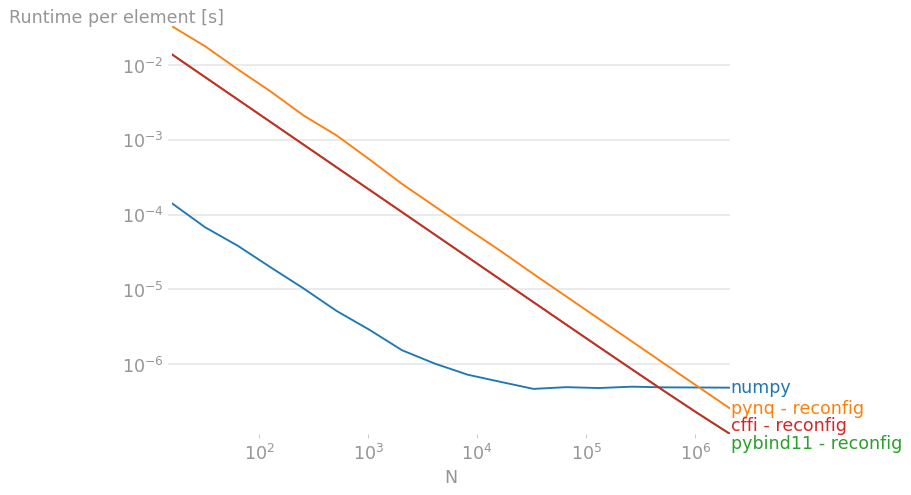

pynq_min_reconf = 1048576
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [10]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/heat_eqn_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [filter_avg_f4_numpy, filter_avg_f4_pynq, filter_avg_f4_pybind11, filter_avg_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/heat_eqn_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sad_reduce_all_f4


kernel = numpy, n = 16, t = 0.0007133877
kernel = pynq, n = 16, t = 0.3093999143
kernel = pybind11, n = 16, t = 0.0004608486
kernel = cffi, n = 16, t = 0.0001935268
kernel = numpy, n = 32, t = 0.0006955849
kernel = pynq, n = 32, t = 0.3087976629
kernel = pybind11, n = 32, t = 0.000195271
kernel = cffi, n = 32, t = 0.0001837434
kernel = numpy, n = 64, t = 0.0007157901
kernel = pynq, n = 64, t = 0.308853717
kernel = pybind11, n = 64, t = 0.00044577600000000005
kernel = cffi, n = 64, t = 0.0001943898
kernel = numpy, n = 128, t = 0.0007403874
kernel = pynq, n = 128, t = 0.3094559414
kernel = pybind11, n = 128, t = 0.0002120154
kernel = cffi, n = 128, t = 0.00018679970000000002
kernel = numpy, n = 256, t = 0.0007723855000000001
kernel = pynq, n = 256, t = 0.3091585598
kernel = pybind11, n = 256, t = 0.00044821720000000006
kernel = cffi, n = 256, t = 0.00020922300000000003
kernel = numpy, n = 512, t = 0.0008497167000000001
kernel = pynq, n = 512, t = 0.30890328330000005
kernel = pybind11, n 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 4.458673125e-05    │ 0.01933749464375  │ 2.88030375e-05     │ 1.2095425e-05     │
│ 32      │ 2.1737028125e-05   │ 0.009649926965625 │ 6.10221875e-06     │ 5.74198125e-06    │
│ 64      │ 1.11842203125e-05  │ 0.004825839328125 │ 6.965250000000001… │ 3.037340625e-06   │
│ 128     │ 5.7842765625e-06   │ 0.00241762454218… │ 1.6563703125e-06   │ 1.45937265625000… │
│ 256     │ 3.017130859375000… │ 0.00120765062421… │ 1.750848437500000… │ 8.17277343750000… │
│ 512     │ 1.659602929687500… │ 0.00060332672519… │ 8.833025390625001… │ 3.88048828125e-07 │
│ 1024    │ 9.782841796875001… │ 0.00030174543730… │ 2.033091796875e-07 │ 1.903701171875e-… │
│ 2048    │ 6.7119033203125e-… │ 0.00015085965932… │ 2.333739257812500… │ 1.01592578125000… │
│ 4096    │ 4.98375830078125e… │ 7.54353788818359… │ 1.211025390625e-07 │ 5.50217041015625… │
│ 8192    │ 4.033862426757813… │ 3.77367688842773… │ 3.526300048828125… │ 4.07139038085937… │
│ 16384   │ 3.604256896972656… │ 1.88685544006347… │ 3.768887329101563… │ 2.41849304199218… │
│ 32768   │ 3.388989013671875… │ 9.42819498901367… │ 1.644985961914062… │ 1.89631378173828… │
│ 65536   │ 3.352504409790039… │ 4.86533411254882… │ 1.328497772216797… │ 1.28070388793945… │
│ 131072  │ 3.410309303283691… │ 2.35985128860473… │ 1.247663192749023… │ 1.14358749389648… │
│ 262144  │ 3.442440170288086… │ 1.18037714614868… │ 1.086641426086425… │ 1.07549907684326… │
│ 524288  │ 3.402755428314209… │ 5.90108675193786… │ 1.043526287078857… │ 1.03705520629882… │
│ 1048576 │ 3.391896379470825… │ 2.97017668056488… │ 1.020188245773315… │ 1.02009221076965… │
│ 2097152 │ 3.381688961982727… │ 1.48890902662277… │ 1.010542087554931… │ 1.01056282043457… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

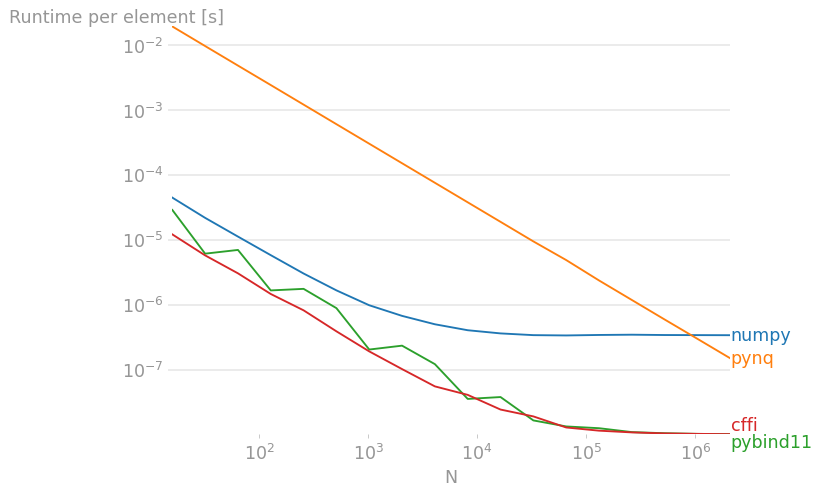

pynq_min = 524288
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.21867898800000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 4.458673125e-05    │ 0.03300493139375… │ 0.013696239787500… │ 0.01367953217500… │
│ 32      │ 2.1737028125e-05   │ 0.016483645340625 │ 0.006839820593750… │ 0.00683946035625  │
│ 64      │ 1.11842203125e-05  │ 0.008242698515625 │ 0.003423824437500… │ 0.00341989652812… │
│ 128     │ 5.7842765625e-06   │ 0.00412605413593… │ 0.0017100859640625 │ 0.00170988896640… │
│ 256     │ 3.017130859375000… │ 0.00206186542109… │ 0.0008559656453125 │ 0.00085503207421… │
│ 512     │ 1.659602929687500… │ 0.00103043412363… │ 0.000427990700976… │ 0.00042749544726… │
│ 1024    │ 9.782841796875001… │ 0.00051529913652… │ 0.000213757008398… │ 0.00021374406933… │
│ 2048    │ 6.7119033203125e-… │ 0.00025763650893… │ 0.000107010223535… │ 0.00010687844218… │
│ 4096    │ 4.98375830078125e… │ 0.00012882380368… │ 5.350952734375000… │ 5.34434465087890… │
│ 8192    │ 4.033862426757813… │ 6.44309812866211… │ 2.672947540283203… │ 2.67349263061523… │
│ 16384   │ 3.604256896972656… │ 3.22156606018066… │ 1.338479507446289… │ 1.33712911315917… │
│ 32768   │ 3.388989013671875… │ 1.61017480895996… │ 6.690002960205079… │ 6.69251623840332… │
│ 65536   │ 3.352504409790039… │ 8.20211066284179… │ 3.350061528015137… │ 3.34958358917236… │
│ 131072  │ 3.410309303283691… │ 4.02823956375122… │ 1.680864907073974… │ 1.67982415008544… │
│ 262144  │ 3.442440170288086… │ 2.01457128372192… │ 8.450605518341065… │ 8.44949128341674… │
│ 524288  │ 3.402755428314209… │ 1.00720574398040… │ 4.275323316574097… │ 4.27467620849609… │
│ 1048576 │ 3.391896379470825… │ 5.05566202449798… │ 2.187504168510437… │ 2.18749456501007… │
│ 2097152 │ 3.381688961982727… │ 2.53165169858932… │ 1.143796880722046… │ 1.14379895401000… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

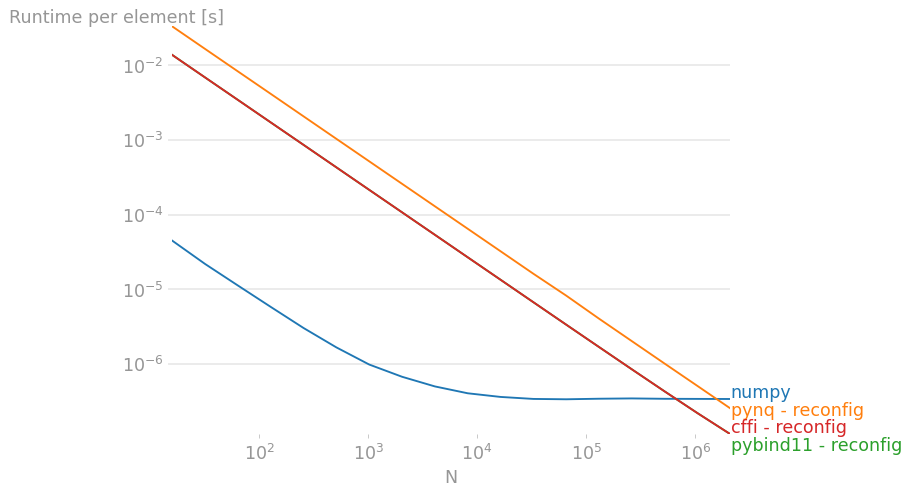

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [11]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/heat_eqn_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    x2 = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)

    return x1, x2

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sad_reduce_all_f4_numpy, sad_reduce_all_f4_pynq, sad_reduce_all_f4_pybind11, sad_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/heat_eqn_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")